<a href="https://colab.research.google.com/github/MarceloMendes94/HousePricesRegression/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de explicabilidade em modelos de regressão aplicados a dados imobiliários
Aluno: Marcelo Passamai Mendes  
Orientador: Sérgio Nery Simões  
#Visão geral do Trabalho

<img src="https://drive.google.com/uc?id=1YQKNl8FeQ_h5VsPkGrudGX8EQNfyfGbz"
     alt="sample image"
     style="display: block; margin-right: auto; margin-left: auto; width: 90%;
     box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.2), 0 6px 20px 0 rgba(0, 0, 0, 0.19)" />
## Preparação dos dados
### Obtenção dos dados
Os dados são oriundos da plataforma de competição Kaggle através do link: [Link para base de dados Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques), entretando realizamos o download e também esta disponível através da pasta no google drive do link: [Link para base de dados Google Drive](https://drive.google.com/drive/folders/17RJgo4gSZ3fRR2gr3Ai6KFAFlV6UG6S0?usp=sharing).
### Limpeza de dados
Nessa etapa fizmoes algumas remoções de ruído que impossibilitaria a contrução do modelo de aprendizado de máquina, entre elas:
* Remoção de COLUNAS com alto percentual de nulos acima de 10%
* Remoções de LINHAS com dados nulos abaixo do corte de 10%
* Classificação de colunas consideradas constrantes
    * Frequência acima de 90%

### Verificação de multicolinearidade
Variáveis com dependência possuem impacto próximo na construção de um modelo por esse motivo uma das varaiveis pode ser removida. Nesse contexto utilizamos a Correlação de Phi K, pois ela é capaz de identificar correlação entre variáveis categóricas e numéricas, além disso identifica correlações diferentes da linear.
* Removemos uma das caracteristicas com Valor de Phi K acima  de 0.9


### Tratamento variáveis categóricas
De acordo com dicionário de dados [Link para o dicionario de dados](), ao observar dados categóricos podemos ver que existem dados categóricos: ordináis e não ordinais, sendo assim Aplicamos dois tipos de transformação.
* Ordinal Encoding
* One-hot-Enconding


## Cálculo da importância das características
Para esse processo foi realizado um hold-out 80 20, em seguida um túnel de hiperparamentos para os modelos de **Random Forest Regressor** e **XGboost Regressor**, foi realizado uma validação cruzada K-Fold com K=5.  

Após a csontrução dos modelos de regressão foi realizado a aplicação do SHAP em cada modelo 30 vezes e selecionado as 20 característcas de maior valor SHAP, além disso realizamos outra etapa de treinamento com a configuração de modelo anterior usando todas as características e apenas as com 20 maiores valores de Shap respectivamente para cada modelo.
Para avaliação do modelo foi realizado a métrica R2-Score com uma validação cruzada de monte carlo com 50 rodadas.

# Preparação dos dados

## Obtenção dos dados

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/TCC/house_prices/train.csv').drop("Id",axis=1)

Mounted at /content/drive


In [2]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Limpeza de dados

### Tratamento de nulos

In [3]:
# Verifficando as características com mais valores nulos.
top_null = df.isnull().mean().sort_values(ascending=False)*100
df_nulos = pd.DataFrame(top_null.values, index = top_null.index,
                        columns = ['percentual_nulos'])

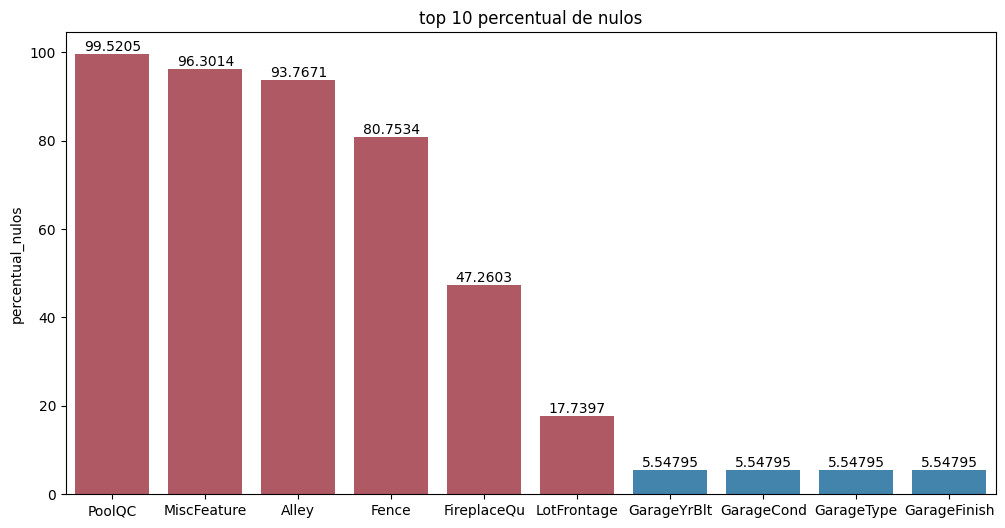

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Gráfico com top 10 nulos

threshold = 10
mask = np.array(df_nulos['percentual_nulos'][0:10]) > threshold

plt.figure(figsize = (12,6))
plt.title('top 10 percentual de nulos')
ax = sns.barplot(y = df_nulos['percentual_nulos'][0:10],
            x = df_nulos.index[0:10],
            palette = np.where(mask, '#BD4B5B', '#3288BD'),
            errwidth = 0)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('top_10_percentual_nulos.pdf')

In [5]:
# Remoção de colunas
colunas_remocao = df_nulos[df_nulos.percentual_nulos > threshold].index
df = df.drop(colunas_remocao, axis = 1)

In [6]:
# Remoção de registros
df = df.dropna(axis = 0)

In [7]:
df.shape

(1338, 74)

### Tratamento de constantes

In [8]:
threshold_constante = 90

In [9]:
df_constantes = pd.DataFrame()
for c in df.columns:
    freq_col = df[c].value_counts(normalize=True)*100
    if ((freq_col.head(1) > threshold_constante).values[0]):
        df_constantes[c] = df[c]

In [10]:
print("Quantidade de dados avaliados como constantes = {qte}\n"\
      .format(qte = df_constantes.shape[1]) +
      "Categóricas = {cat}\n"\
      .format(cat = df_constantes.select_dtypes(include = ['object']).shape[1])+
      "Numéricas = {num}\n"\
      .format(num = df_constantes.select_dtypes(include = ['int64']).shape[1]))


Quantidade de dados avaliados como constantes = 21
Categóricas = 14
Numéricas = 7



In [11]:
# Gráfico



In [12]:
# Remoção
df = df.drop(df_constantes.columns, axis = 1)
df.shape

(1338, 53)

## Verificação de multicolinearidade

In [13]:
# Instalando biblioteca
!pip3 install phik  >/dev/null & echo 'Library Phi K Installed'

Library Phi K Installed


In [14]:
# Calculo de Phi K
import phik
df_phik = df.phik_matrix()

interval columns not set, guessing: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice']


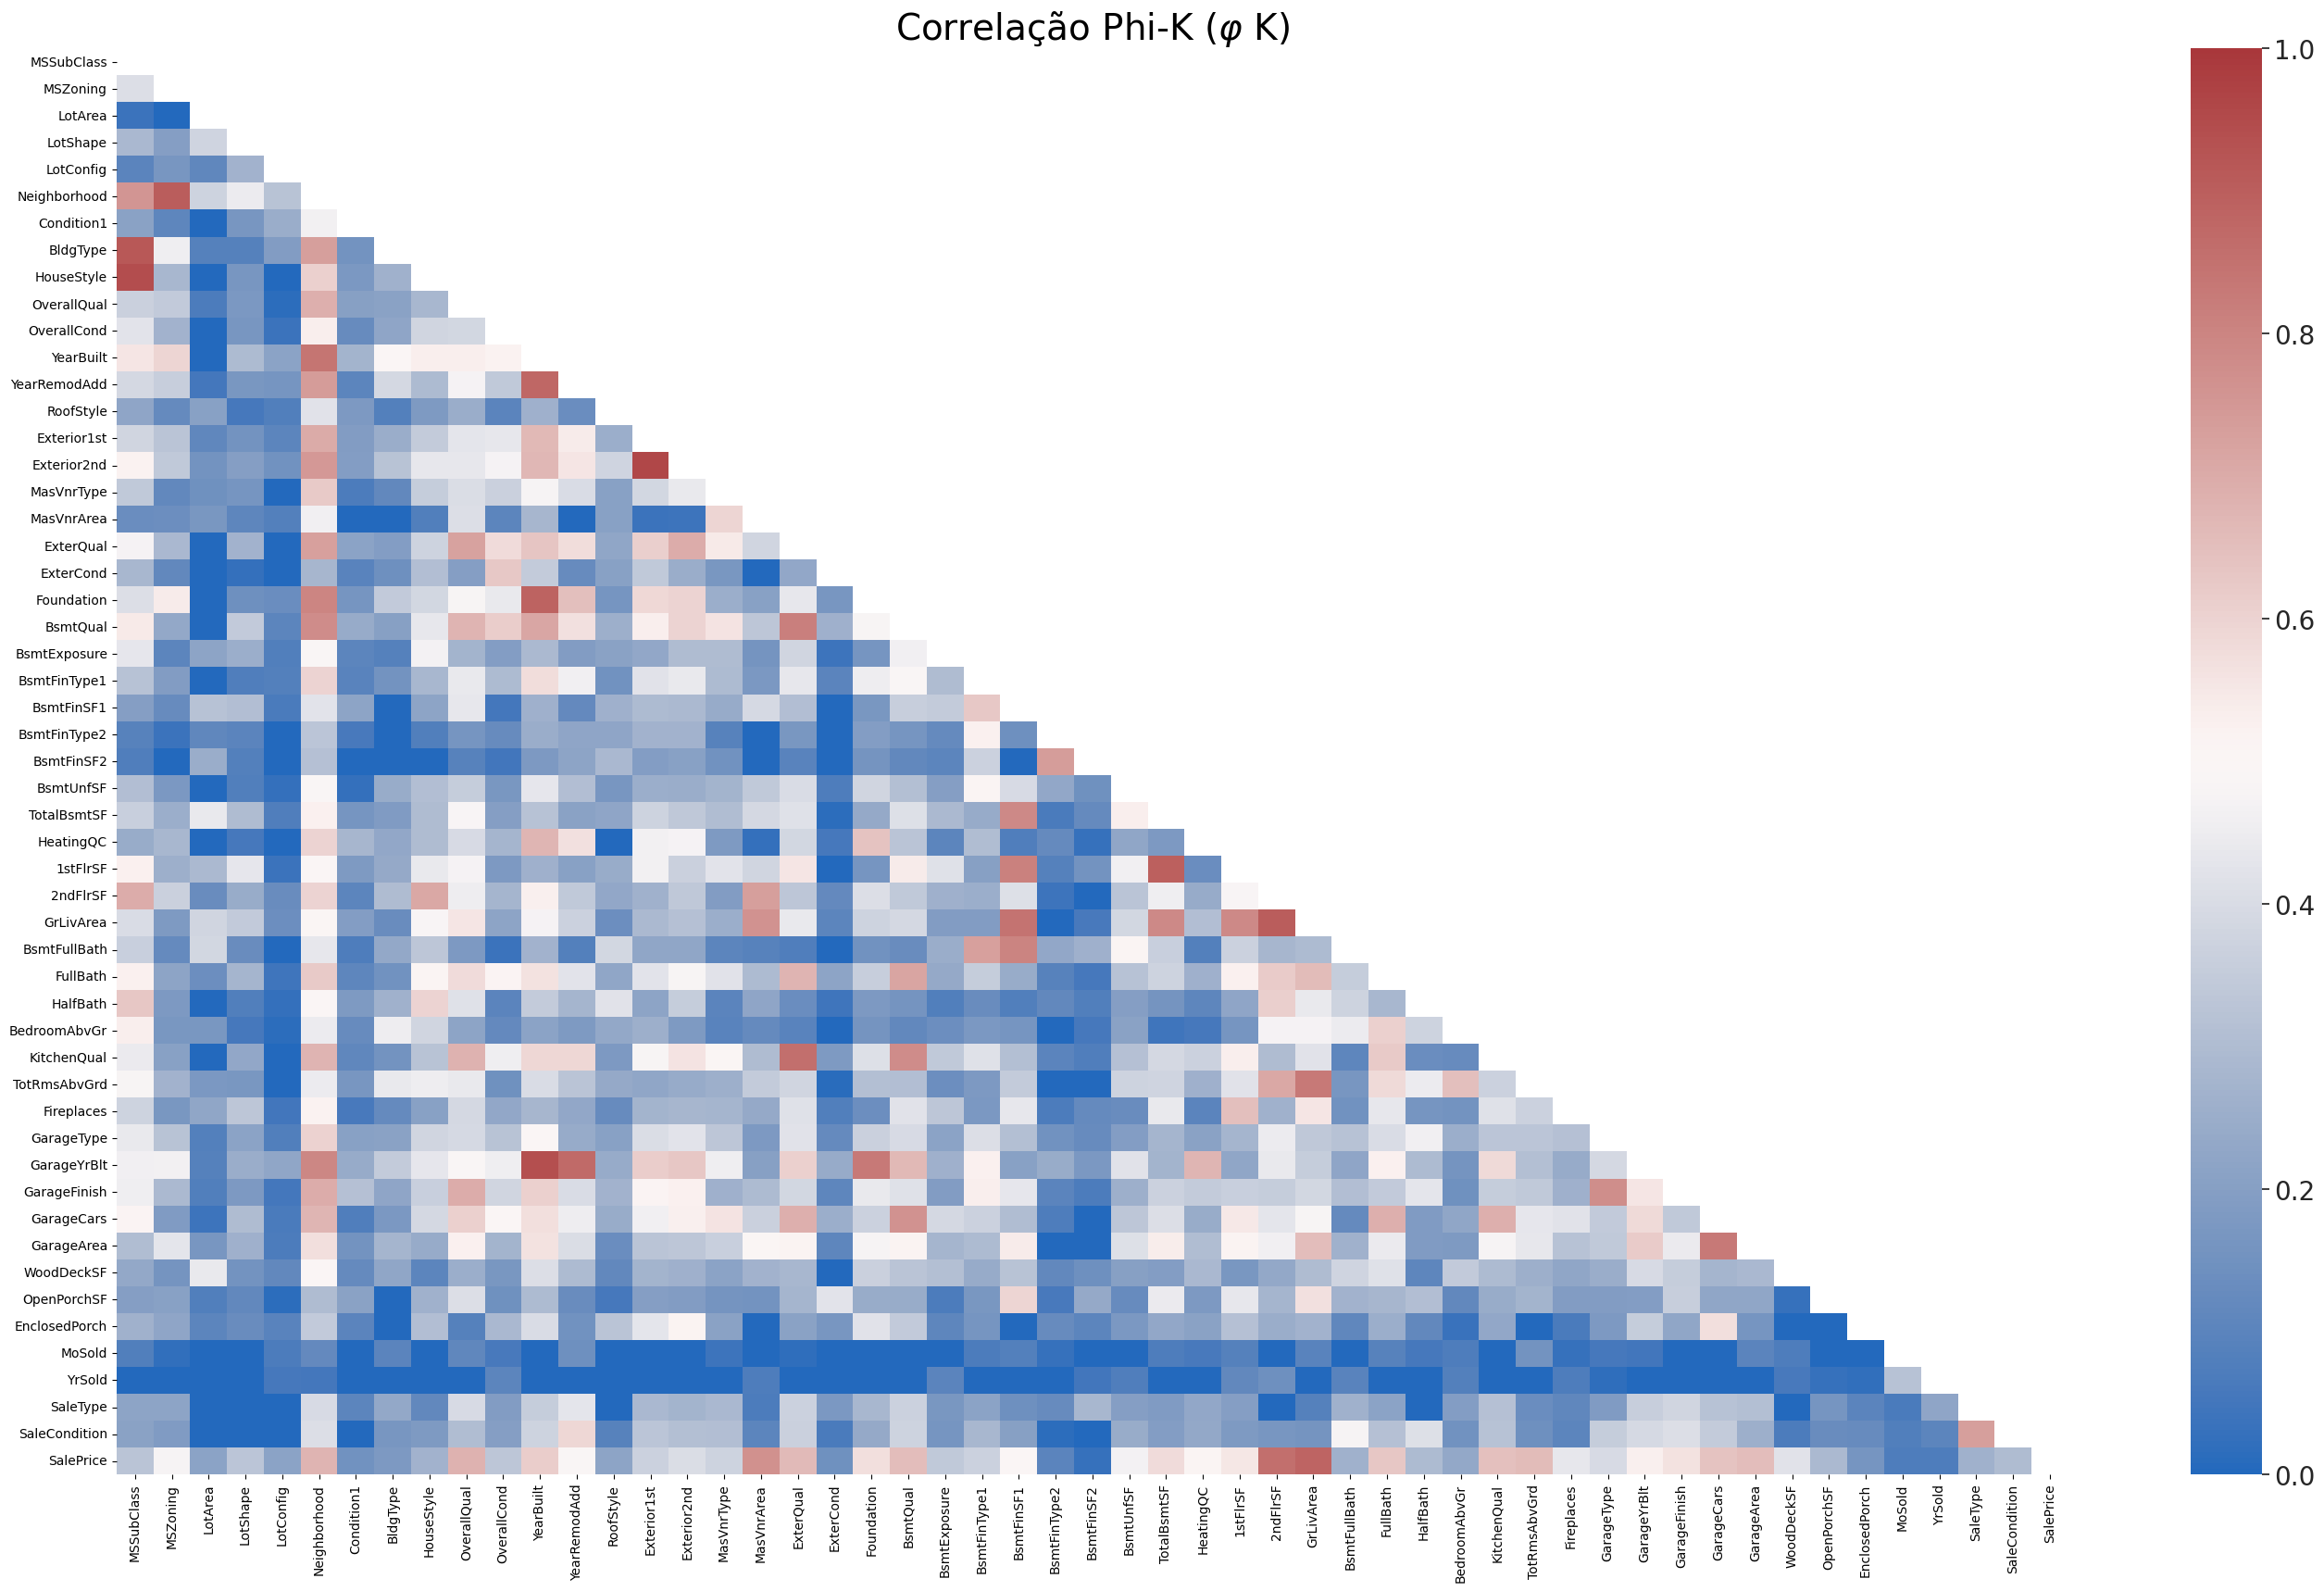

In [15]:
plt.figure(figsize=(34,20))
plt.title(r'Correlação Phi-K ($\varphi$ K)', fontsize=28)
# Construção de uma máscara
# Usando Booleanos pois o phi k vai de 0 a 1
# Com inteiros deu problema
mask = np.triu(np.ones_like(df_phik, dtype = bool))
sns.set(font_scale=1.5)
htm = sns.heatmap(df_phik, annot=False, mask=mask,
                  vmin=0, vmax=1, cmap='vlag',fmt='.2f',)

cbar = htm.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.savefig('triu.pdf')
plt.show()

#### Aplicação do Stack para processamento do dataframe
![stack figure](https://miro.medium.com/v2/resize:fit:720/format:webp/1*DYDOif_qBEgtWfFKUDSf0Q.png)

In [16]:
def data_clean_multicolinearity(df , phi_k_corte,target):
    # caculando o phik Para o dataFrame
    df_phik = df.phik_matrix()

    # construção de uma matriz triangular superior para servir de mascara e eliminar duplicados.
    mask = np.triu(np.ones_like(df_phik, dtype=bool))

    # Aplicação de uma mascara ao dataframe pegando apenas a triangular inferior e removendo a linha do target
    df_phi_k_mask = df_phik.mask(mask).drop(target,axis=0)

    # Aplicação do Stack
    df_phi_k_mask = df_phi_k_mask.stack()

    top_phik = df_phi_k_mask[df_phi_k_mask > phi_k_corte]

    # Transformo a lista de tuplas em uma lista
    feat_phi_k = [item for tupla in top_phik.index for item in tupla]

    # Quais são as caracteristicas que mais aparecem
    freq_feat_phik = pd.DataFrame(feat_phi_k).value_counts()

    # ########################################################################
    lst_candidatos = []

    #Percorre a lista de pares ordenados
    for t in list(top_phik.index):
        prim,seg = t[0],t[1]

        # SE a frequencia de ocorrencia do primeiro é maio que a do segundo
        # E caso o primeiro estja na lista coloca o segundo
        if (freq_feat_phik[prim] > freq_feat_phik[seg]):
            if (prim not in lst_candidatos):
                lst_candidatos.append(prim)
            else:
                lst_candidatos.append(seg)

        elif (freq_feat_phik[seg] > freq_feat_phik[prim]):
            if (seg not in lst_candidatos):
                lst_candidatos.append(seg)
            else:
                lst_candidatos.append(prim)
        else:
            if (prim not in lst_candidatos):
                lst_candidatos.append(prim)
            else:
                lst_candidatos.append(seg)

    return df.drop(lst_candidatos,axis=1)

In [17]:
df = data_clean_multicolinearity(df , 0.9,'SalePrice')

interval columns not set, guessing: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice']


### Categóricas Ordinais

In [18]:
df.replace(['NA','Po','Fa','TA','Gd','Ex'], [0,1,2,3,4,5],inplace=True)

### Categóricas Não Ordinais

In [19]:
df = pd.get_dummies(df)

In [20]:
df.shape

(1338, 128)

# Cálculo da importância de características

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Holdout

In [22]:
X, y = df.drop("SalePrice",axis=1), df["SalePrice"]

X_train, X_test, \
y_train, y_test = train_test_split(X, y,
                                test_size = 0.20)

## Random Forest Regressor

In [23]:
# Parametros para o Túnel
param_rf= {'criterion':['squared_error',\
                        'absolute_error',\
                        'friedman_mse'],
           'max_depth':[2,3,4,5,7],
           'min_samples_split':[2,3,4,5],
           'n_estimators':[100,150,200,250,300]}

In [24]:
# Função com Tunel de hiper parametros.
def random_forest_best_params(param,X_train,y_train):
    gs_rf = GridSearchCV(RandomForestRegressor(),
                             param, scoring='r2',
                             n_jobs=-1,cv=5)
    gs_rf.fit(X_train, y_train)
    return gs_rf.best_params_

O melhor modelo para métrica R2 Score foi :
```
{
  'criterion': 'squared_error',
  'max_depth': 7,
  'min_samples_split': 5,
  'n_estimators': 100
}
```
Para realizar o teste é só descomentar a linha a baixo:

In [25]:
#random_forest_best_params(param_rf,X_train,y_train)

In [26]:
randomforest_r = RandomForestRegressor(criterion = 'squared_error',
                               max_depth = 7,
                               min_samples_split = 5,
                               n_estimators = 100)

## XGBosst Regressor

In [27]:
# Parametros para o Túnel de Params
params_xgb = {\
              'n_estimators':[100,150,200,250,300],
              'max_depth':[2,3,4,5,6,7,11],
               'eta':[0.1,0.2,0.3,0.4,0.5],
            }

In [28]:
def xgb_best_params(params,X_train,y_train):
    gs_xgb = GridSearchCV(
        XGBRegressor(),
        params,
        scoring='r2',
        n_jobs=-1, cv=5)
    gs_xgb.fit(X_train, y_train)
    return gs_xgb.best_params_

Entre esses valores o melhor modelo foi:
```
{
    'n_estimators'= 500,
    'max_depth' = 2,
    'eta' = 0.1
}
```
Para realizar o teste é só descomentar a linha a baixo:

In [29]:
#xgb_best_params(params_xgb,X_train,y_train)

In [30]:
xgboost_r = XGBRegressor(n_estimators = 500,max_depth = 2, eta = 0.1)

## Validação cruzada 5-fold na métrica R2-Score

In [31]:
rf_reg, xg_reg = randomforest_r, xgboost_r
rf_reg.fit(X_train, y_train)
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [32]:
cv = 5

In [33]:
rf_scores = cross_val_score(rf_reg, X, y, cv=cv, scoring = 'r2')

In [34]:
xgb_scores = cross_val_score(xg_reg, X, y, cv=cv, scoring = 'r2')

In [35]:
df_Kfold = pd.DataFrame({"Random Forest":rf_scores,"XGBoost":xgb_scores})

In [36]:
def boxplot_sorted(df, score, title, rot=90, figsize=(10,6), fontsize=12):
    df2 = df.T
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, fontsize=fontsize,
                                   boxprops=dict(linewidth=4, color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, color='firebrick'),
                                   capprops=dict(linewidth=4, color='cornflowerblue'),
                                   flierprops=dict(marker='o', markerfacecolor='dimgray',
                                        markersize=12, markeredgecolor='black'),
                                   return_type="axes")
    axes.set_title(title, fontsize=fontsize)
    plt.savefig(title + '.pdf')
    plt.show()

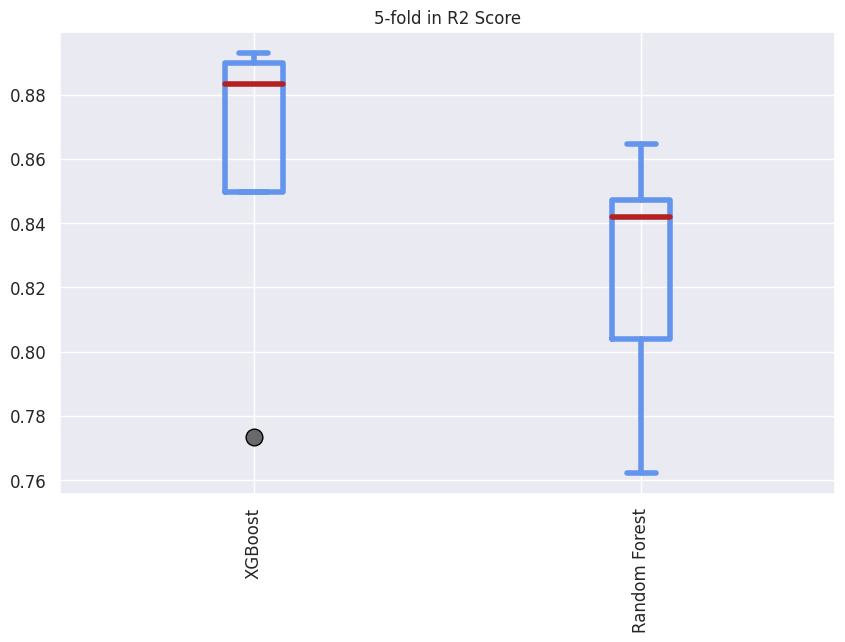

In [37]:
boxplot_sorted(df_Kfold.T, 'r2', '5-fold in R2 Score', rot=90, figsize=(10,6), fontsize=12)

## Shap

Essa função roda o SHAP N vezes  com hold-out aleatórios e retorna uma dataframe com resultado de cada rodada.

Isto foi realizado para testar a **robustez** dos resultados do SHAP.

In [38]:
!pip install shap >/dev/null & echo "SHAP Installed"

SHAP Installed


In [39]:
import shap
import random

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [41]:
def evaluate_shap(model, X, y, times = 5):
    df = pd.DataFrame()
    #split = vet_rand(times)

    for t in range(times):
        # Hold-out
        X_train, X_test,\
        y_train, y_test = train_test_split(X, y, test_size = 0.2)


        # Treinamento do modelo
        model.fit(X_train, y_train)

        # Aplicar Shap
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_train)

        # gerando gráficos
        if t==0:
            #analise global
            shap.plots.beeswarm(shap_values, max_display = 21,show=False)
            plt.savefig('global_shap_beeswarm.pdf', format='pdf', dpi=600, bbox_inches='tight')
            plt.show()

            shap.plots.bar(shap_values, max_display = 21, show = False)
            plt.savefig('global_shap_bar.pdf', format = 'pdf', dpi = 600, bbox_inches = 'tight')
            plt.show()

            #analise local
            shap.initjs()
            shap.plots.force(shap_values[0],matplotlib = True,show = False)
            plt.savefig('local_shap_forces.pdf', format = 'pdf', dpi = 600, bbox_inches = 'tight')
            plt.show()

            shap.plots.waterfall(shap_values[0],max_display = 15, show = False)
            plt.savefig('local_shap_waterfall.pdf', format = 'pdf', dpi = 600, bbox_inches = 'tight')
            plt.show()

            ###
            shap.initjs()
            shap.plots.force(shap_values[1],matplotlib = True,show = False)
            plt.savefig('local_shap_forces1.pdf', format = 'pdf', dpi = 600, bbox_inches = 'tight')
            plt.show()

            shap.plots.waterfall(shap_values[1],max_display = 15, show = False)
            plt.savefig('local_shap_waterfall1.pdf', format = 'pdf', dpi = 600, bbox_inches = 'tight')
            plt.show()


        # Captura das top Features com base no shap
        d = { t: [np.abs(i) for i in shap_values.values.mean(axis=0)] }
        if t == 0:
            df = pd.DataFrame(d)
        else:
            df = pd.concat([df, pd.DataFrame(d)], axis = 1)

    df = df.T
    df.columns = [i for i in shap_values.feature_names]

    return df

In [42]:
shap_n_feat = 20
shap_times = 30

### Random Forest

 98%|===================| 1052/1070 [00:20<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


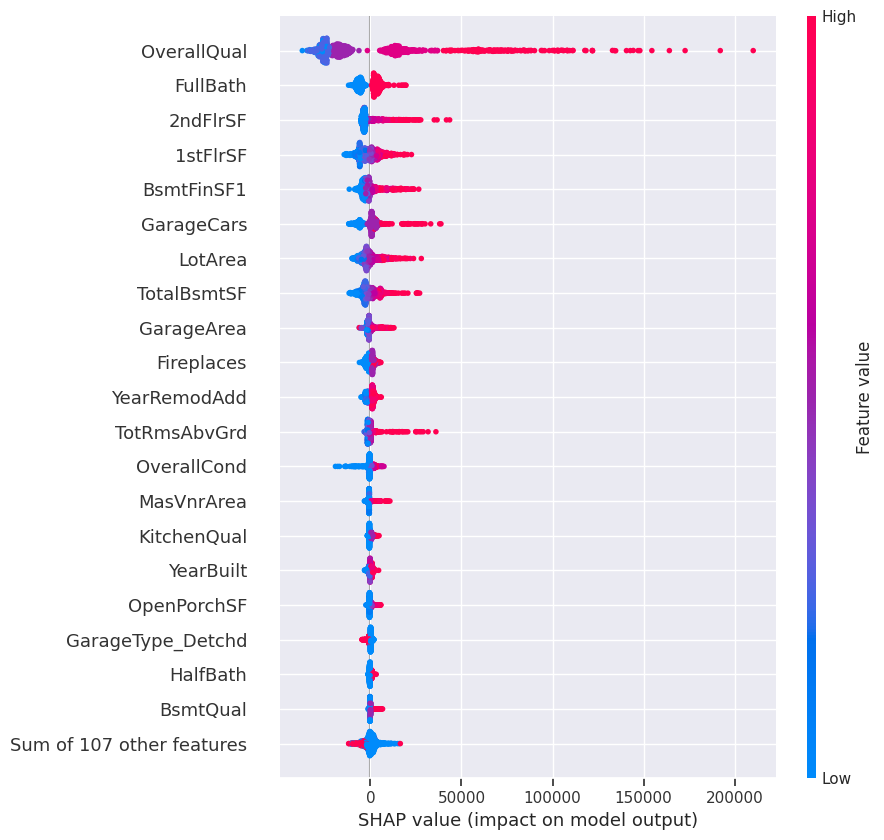

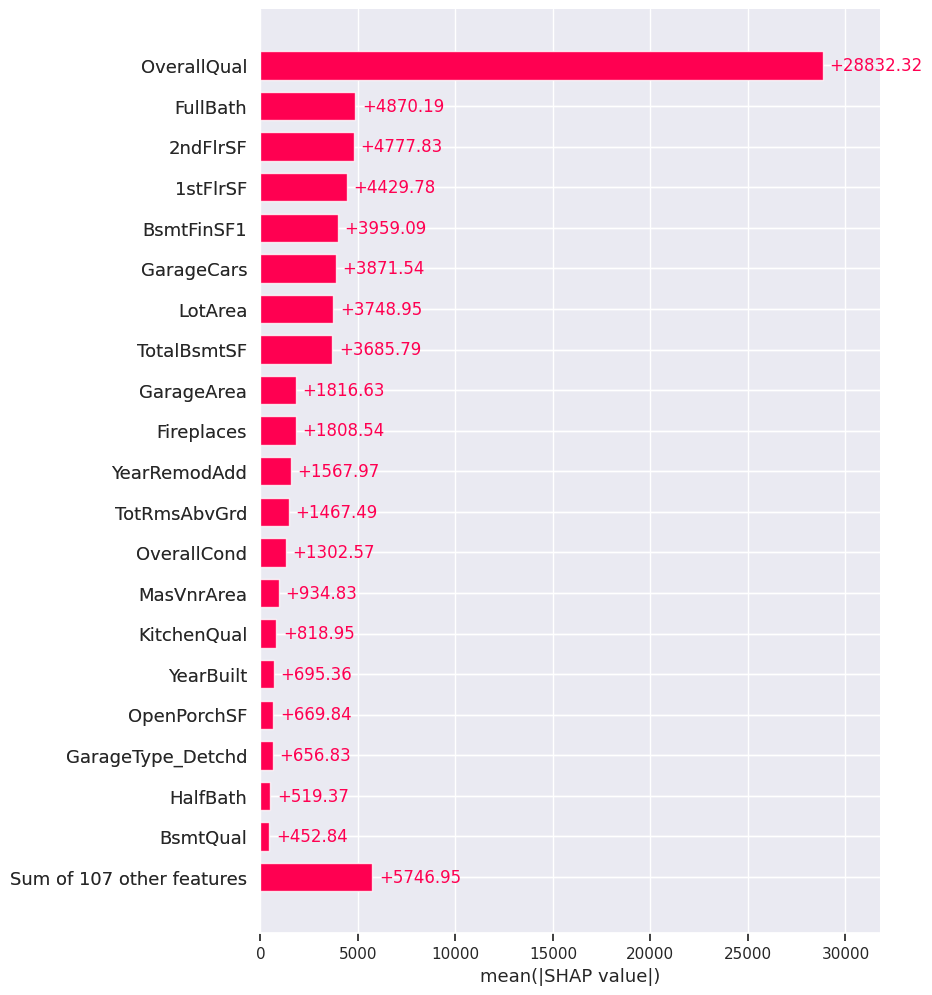

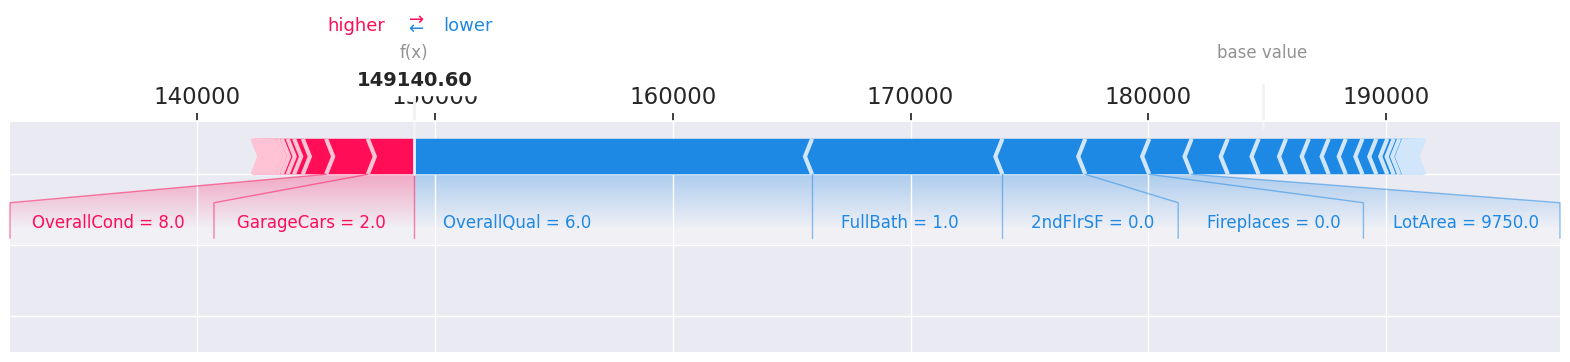

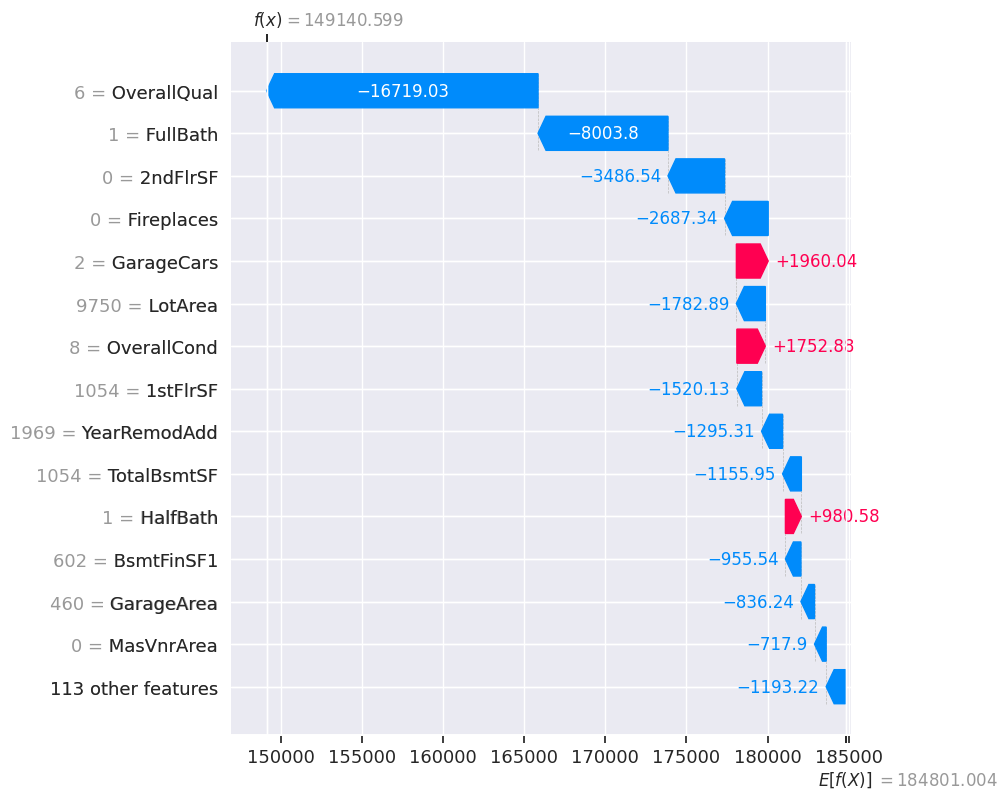

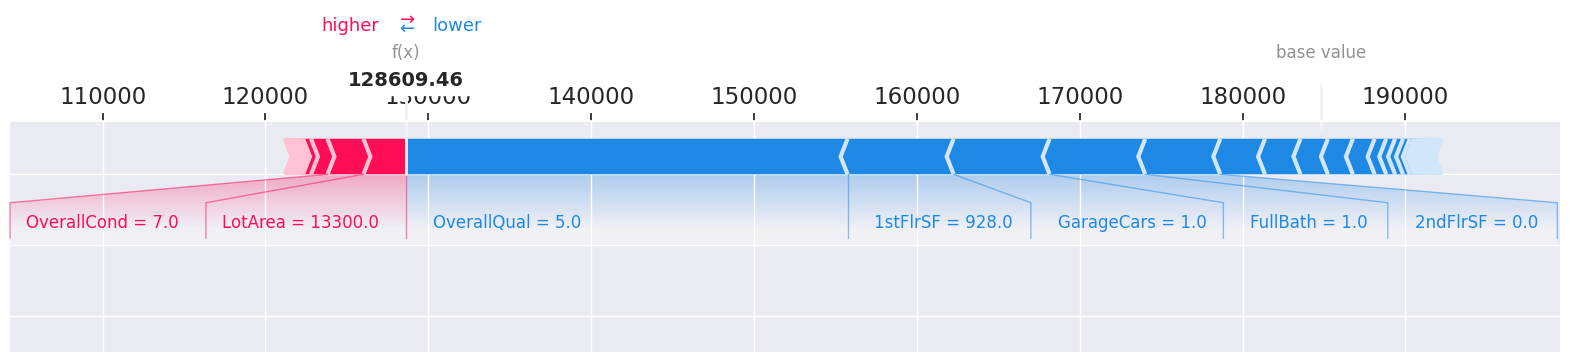

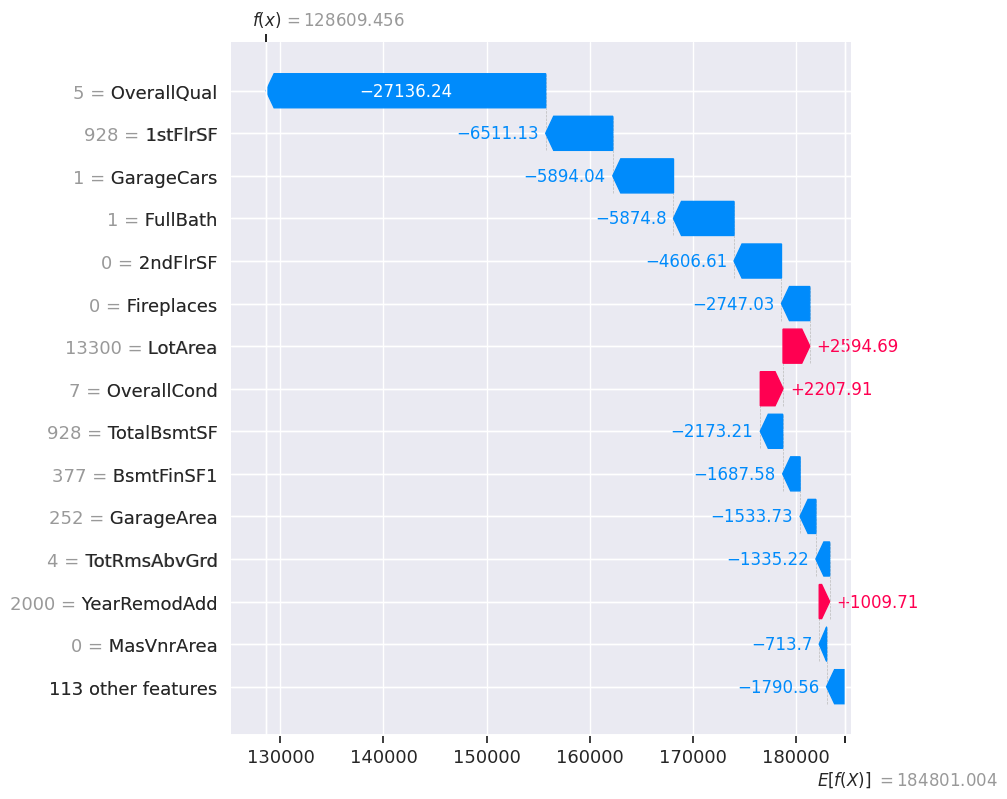

 97%|=================== | 1039/1070 [00:11<00:00]       

In [43]:
# redução de dimensionalidade para o random forest
shap_rf = evaluate_shap(randomforest_r, X, y, shap_times)

In [44]:
# escolha das 15 caracteristicas globais mais importantes
candidatos_rf = list(shap_rf.mean().sort_values(ascending = False)\
 [:shap_n_feat].index)

In [45]:
candidatos_rf

['OverallQual',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LotArea',
 'BsmtFinSF1',
 'GarageCars',
 'MasVnrArea',
 'GarageArea',
 'Fireplaces',
 'TotRmsAbvGrd',
 'OverallCond',
 'OpenPorchSF',
 'BsmtQual',
 'YearBuilt',
 'HalfBath',
 'YearRemodAdd',
 'GarageType_Detchd',
 'BldgType_1Fam']

### XGBoost

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


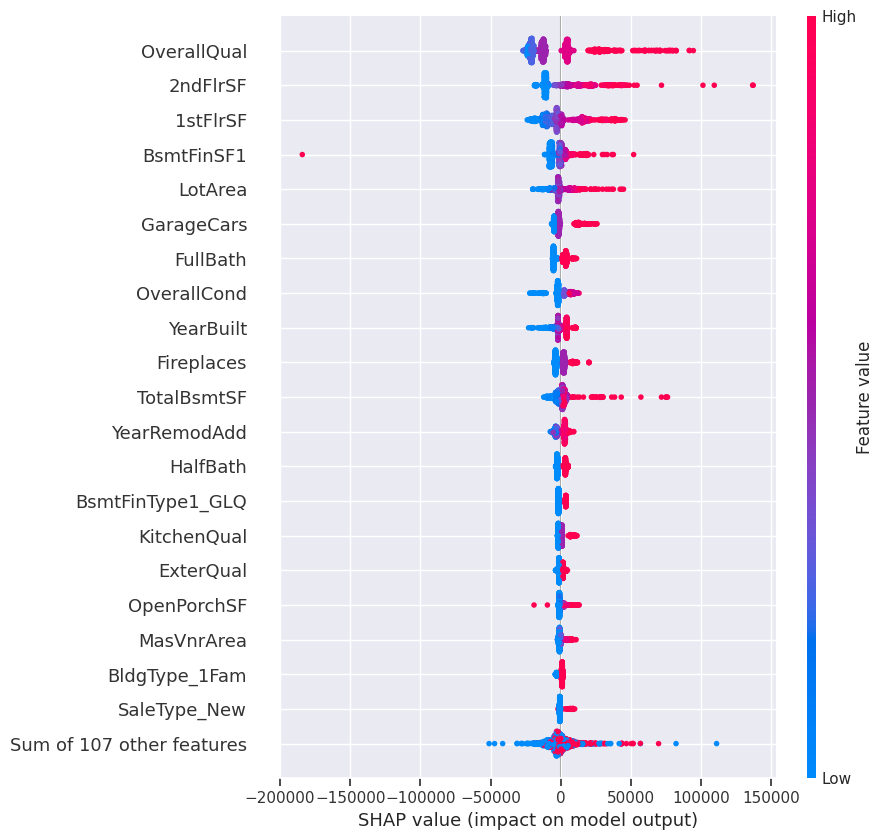

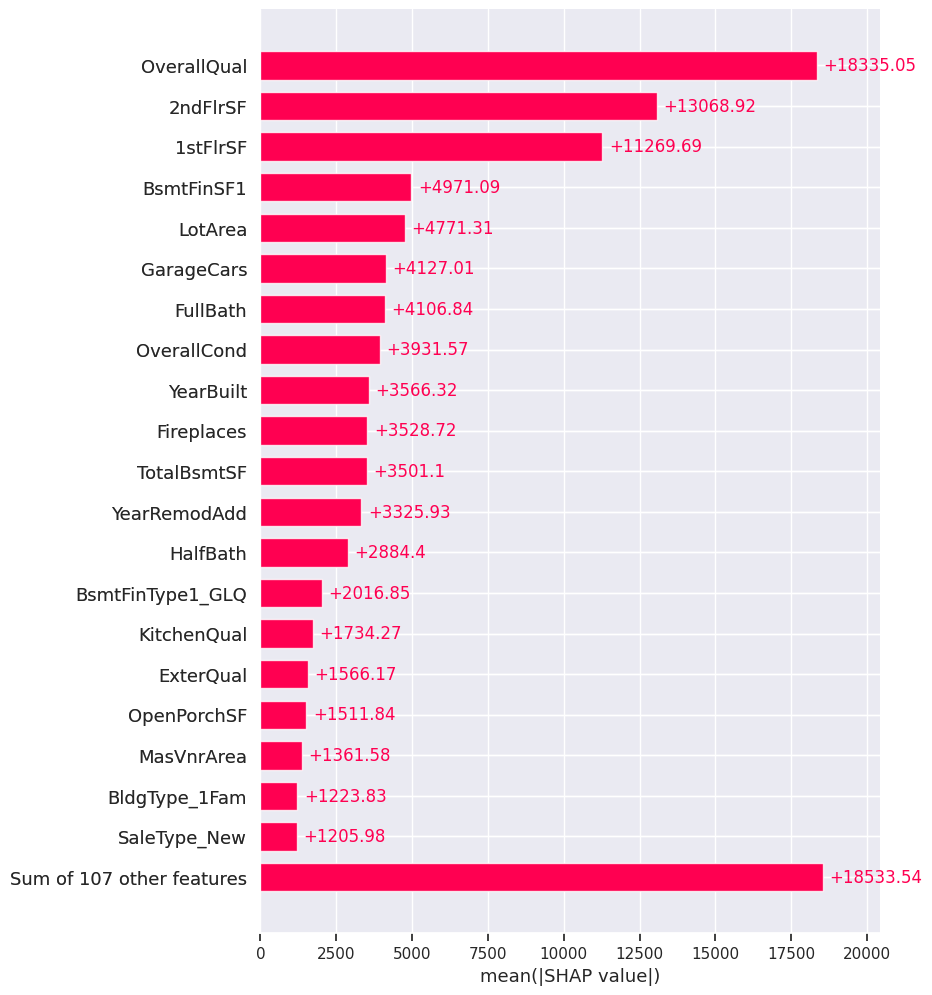

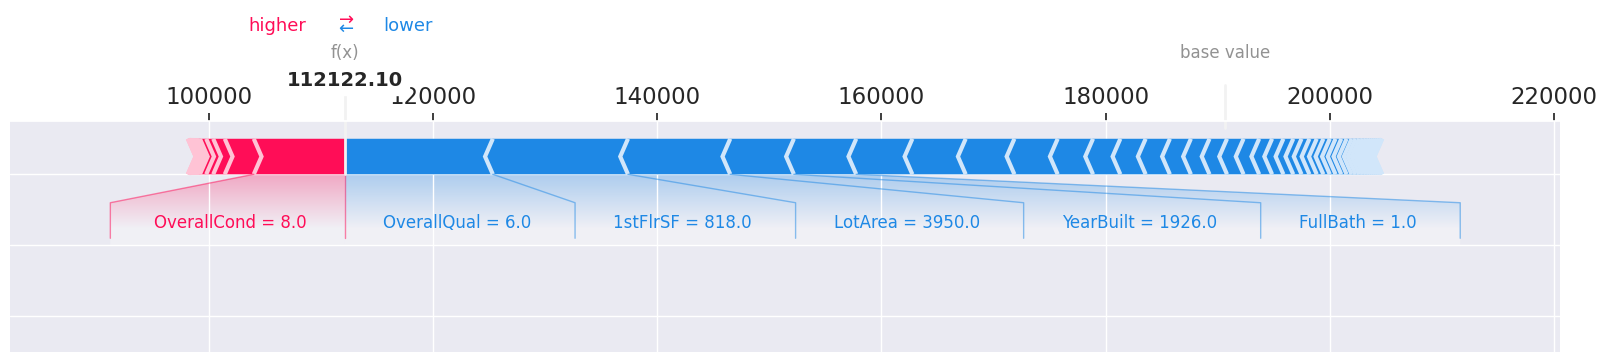

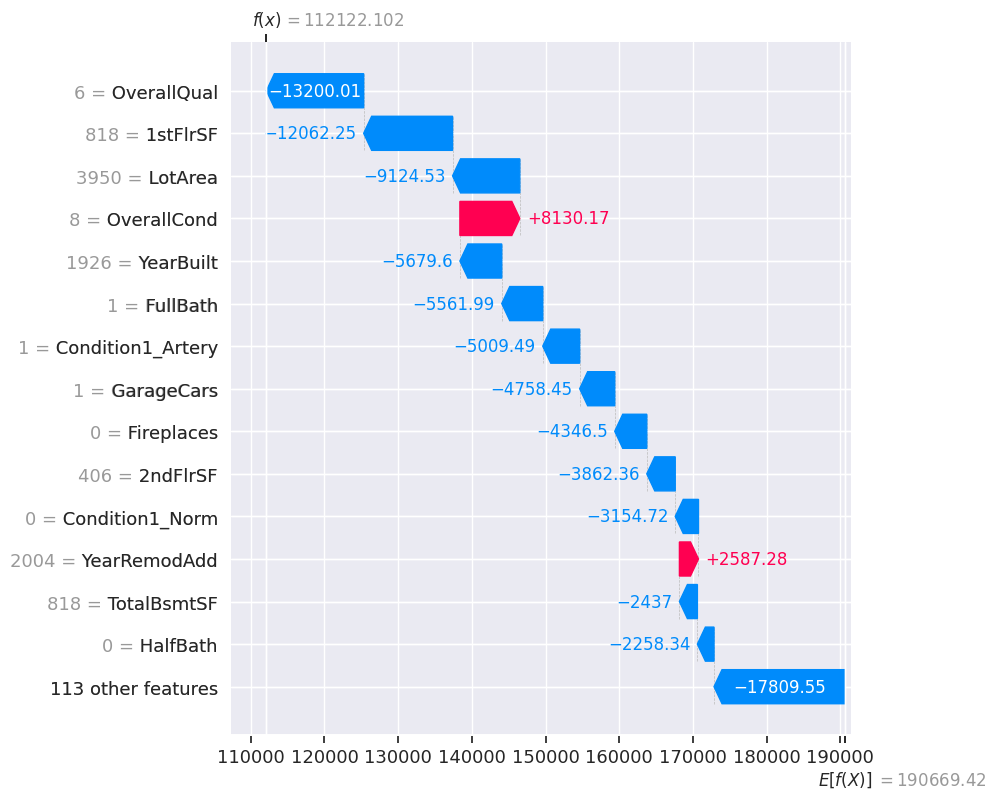

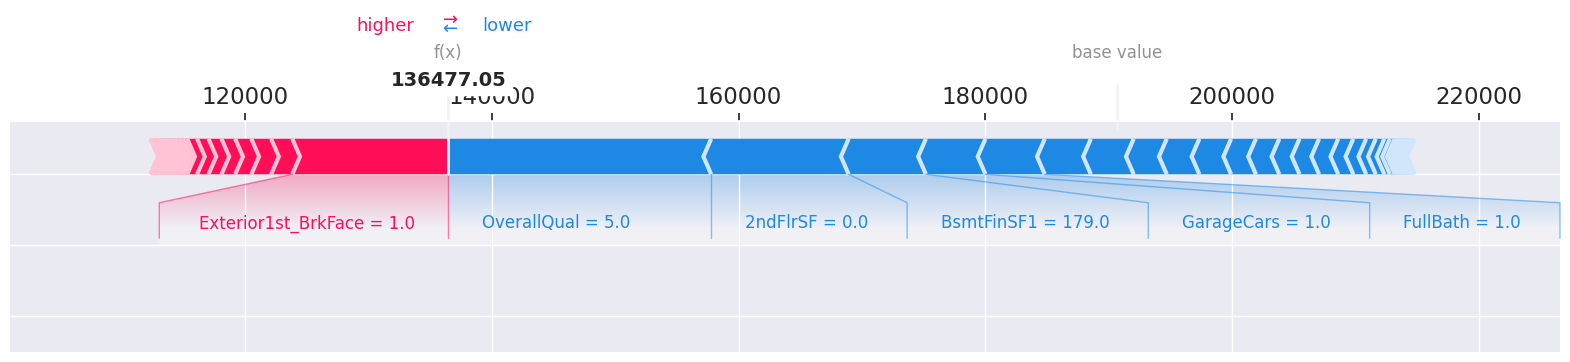

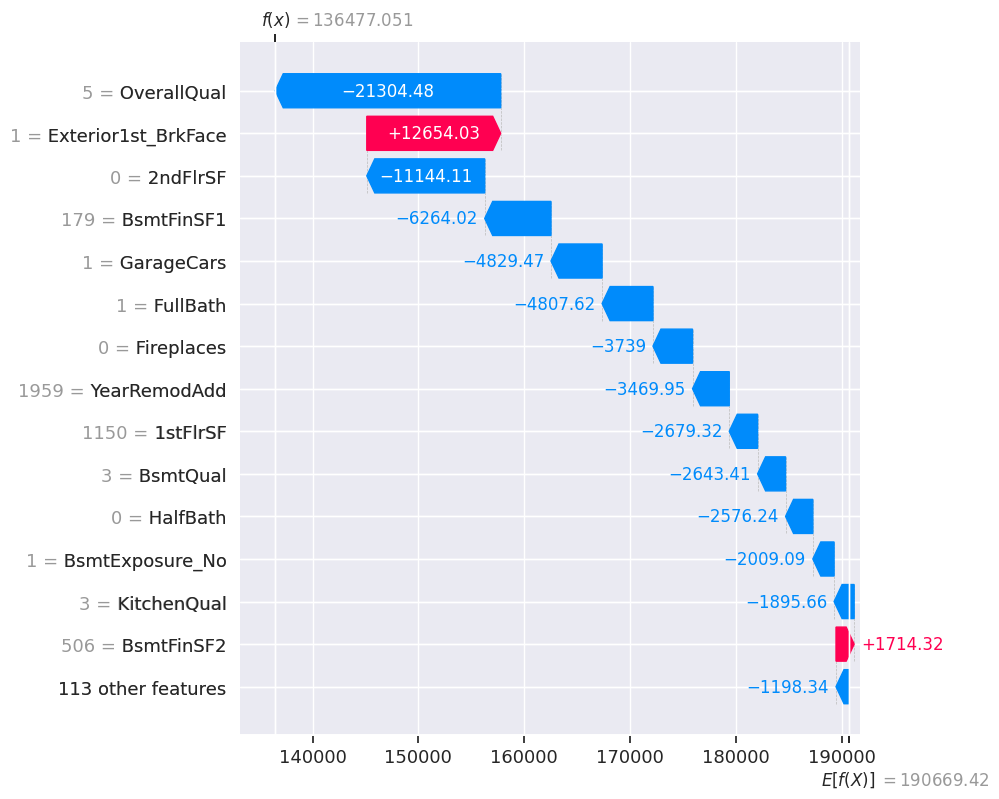

In [46]:
# redução de dimensionalidade para o XGBosst
shap_xgb = evaluate_shap(xgboost_r, X, y, shap_times)

In [47]:
# escolha das N caracteristica mais importantes.
candidatos_xgb = list(shap_xgb.mean().sort_values(ascending = False)\
[:shap_n_feat].index)

In [48]:
candidatos_xgb

['OverallQual',
 '2ndFlrSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'OverallCond',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 '1stFlrSF',
 'KitchenQual',
 'Fireplaces',
 'HalfBath',
 'SaleType_New',
 'WoodDeckSF',
 'BldgType_1Fam',
 'BsmtUnfSF',
 'Condition1_Norm',
 'GarageArea',
 'LotArea',
 'Exterior1st_BrkFace']

## Redução de dimensionalidade

In [49]:
lista = {
    'Random Forest':[randomforest_r, candidatos_rf],
    'XGBoost ':[xgboost_r,candidatos_xgb]
    }

In [50]:
def train_and_r2(model,X_train, X_test, y_train, y_test ):
    model.fit(X_train, y_train)
    # Avaliação do modelo
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    return score

In [51]:
def evaluate(models, X, y,label, times = 50):

    dicio={}
    lst_keys = models.keys()
    for i in lst_keys:
        dicio[i] = []
        dicio[i + ' Reduced'] = []

    for i in range(times):

        # Hold-out
        X_train, X_test, \
        y_train, y_test = train_test_split(X, y, test_size = 0.20)

        #Para cada modelo faça:
        for key in lst_keys:
            # treinar o modelo COMPLETO, avaliar e  salvar.
            model = models[key][0]
            dicio[key].append(train_and_r2(model, X_train, X_test, y_train, y_test))

            # treinar o modelo REDUZIDO, avaliar e  salvar.
            feat = models[key][1]
            dicio[key+ ' Reduced'].append(
                train_and_r2(model, X_train[feat], X_test[feat], y_train, y_test))

    return pd.DataFrame(dicio)

In [52]:
df_r2 = evaluate(lista, X, y,'marcelo')
df_r2.describe()

,Random Forest,Random Forest Reduced,XGBoost,XGBoost Reduced
count,50.000000,50.000000,50.000000,50.000000
mean,0.819212,0.825567,0.851666,0.850770
std,0.048495,0.047227,0.072193,0.069032
min,0.652475,0.651343,0.592141,0.552646
25%,0.787640,0.800599,0.814606,0.850903
50%,0.830950,0.838658,0.877574,0.868329
75%,0.855860,0.859620,0.900517,0.889428
max,0.888601,0.899348,0.943526,0.919428


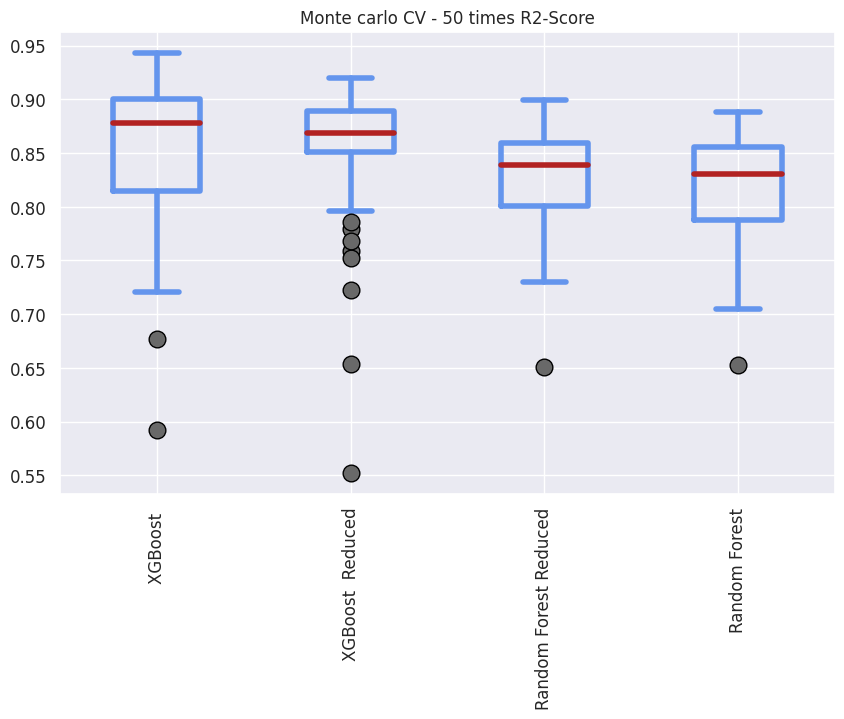

In [53]:
boxplot_sorted(df_r2.T, 'r2', 'Monte carlo CV - 50 times R2-Score', rot=90, figsize=(10,6), fontsize=12)